In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm

In [2]:
# defininf the states
# defininsg coefficeients sybols

def Creating_states(coeff, Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])

In [3]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrix

M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix


In [4]:
#Creating function for the deltarho error

def experiment_rho(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
    
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    return error



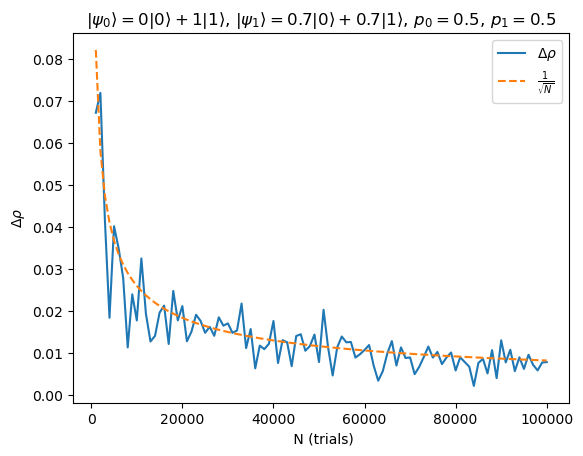

100
Error Converged to:  0.0072448434405160324


In [19]:

coeff = [0,1,1/(2**.5),1/(2**.5)] #1/(2**.5)
priors = [.5,.5]
trials = [1000*(i+1) for i in range(100)]

sqrtN  = [2.6/(i**.5) for i in trials]     # ideal square root shape with a constant multiplied for scaling
errors = [experiment_rho(i,coeff,priors,POVM_elts, M_inv) for i in trials]

plt.plot(trials, errors, label=r'$\Delta \rho $')
plt.plot(trials ,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
plt.xlabel(' N (trials)')
plt.ylabel(r'$\Delta \rho $')
plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={},\,p_1={}$'.format(round(coeff[0],1), round(coeff[1],1), round(coeff[2],1), round(coeff[3],1), priors[0], priors[1]))
plt.legend()

plt.show()

print(f'Error Converged to: ' , experiment_rho( 1000*100 ,coeff,priors,POVM_elts, M_inv))

In [24]:
'''#Creating function for the deltarho error

def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2

def experiment_fid(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    f0t = np.conj(psi0[0])/np.conj(psi0[1]) #theoretical f0
    f1t = np.conj(psi1[0])/np.conj(psi1[1]) #theoretical f1

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
     
    eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    index = np.argmin(evals)
    eigenvector = eigenvectors[:,index]
    c00 = eigenvector[0]
    c01 = eigenvector[1]
    c11 = eigenvector[2]
    f0,f1 = solve_quadratic(c00, 2*c01, c11)
    if (f0t<=f1t):
        a0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        a1 = 1/(m.sqrt(1+ (abs(f0))**2))
        b0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        b1 = 1/(m.sqrt(1+ (abs(f1))**2))
    else:
        a0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        a1 = 1/(m.sqrt(1+ (abs(f1))**2))
        b0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        b1 = 1/(m.sqrt(1+ (abs(f0))**2))
    psi0_num = [a0,a1]
    psi1_num = [b0,b1]
    fid0 = abs(np.dot(psi0_num,psi0))**2
    fid1 = abs(np.dot(psi1_num,psi1))**2
    fid = [fid0,fid1]
    f = [f0,f1]
    #return [psi0_num,psi1_num,fid,f0,f1]
    return fid'''

In [69]:
#Creating function for the deltarho error

def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2

def experiment_fid(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    f0t = np.conj(psi0[0])/np.conj(psi0[1]) #theoretical f0
    f1t = np.conj(psi1[0])/np.conj(psi1[1]) #theoretical f1

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
     
    eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    index = np.argmin(evals)
    eigenvector = eigenvectors[:,index]
    c00=eigenvector[0]
    c01=eigenvector[1]
    c11=eigenvector[2]
    f0,f1=solve_quadratic(c00, 2*c01, c11)
    if (f0t<=f1t):
        a0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        a1 = 1/(m.sqrt(1+ (abs(f1))**2))
        b0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        b1 = 1/(m.sqrt(1+ (abs(f0))**2)) 
    else:
        a0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        a1 = 1/(m.sqrt(1+ (abs(f0))**2))
        b0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        b1 = 1/(m.sqrt(1+ (abs(f1))**2))
    psi0_num = [a0,a1]
    psi1_num = [b0,b1]
    #print(psi0_num,psi1_num)
    psi0 = [coeff[0],coeff[1]]
    psi1 = [coeff[2],coeff[3]]
    fid0 = abs(np.vdot(psi0_num,psi0))**2
    fid1 = abs(np.vdot(psi1_num,psi1))**2
    fid = [fid0,fid1]
    f = [f0,f1]

    return fid

C:\Users\camipolv\AppData\Local\Temp\ipykernel_22404\4234730624.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  f1t = np.conj(psi1[0])/np.conj(psi1[1]) #theoretical f1


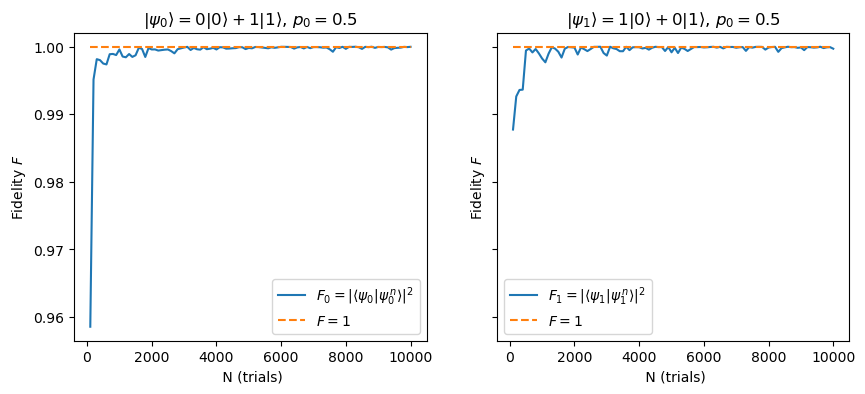

In [72]:
coeff = [0,1,1,0] #1/(2**.5)
priors = [.5,.5]
trials = [100*(i+1) for i in range(100)]


pfid  = [1 for i in trials]    # perfect fidelity of 1
output = [experiment_fid(i,coeff,priors,POVM_elts, M_inv) for i in trials]
outputt = list(map(list, zip(*output)))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1.plot(trials, outputt[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1.plot(trials , pfid, "--", label=r'$F=1$')
ax1.set_xlabel(' N (trials)')
ax1.set_ylabel(r'Fidelity $F$')
ax1.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1.legend(loc='best')

ax2.plot(trials, outputt[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2.plot(trials , pfid, "--", label=r'$F=1$')
ax2.set_xlabel(' N (trials)')
ax2.set_ylabel(r'Fidelity $F$')
ax2.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2.legend(loc='best')

plt.show()

#print(f0t,output[1][0])
#print(f1t,output[1][1])

In [15]:
#plot fidelity F0,1 as a function of priors p0,1 and of coefficients a0,1,b0,1

